In [2]:
import numpy as np
import sympy as sp
import open3d as o3d
import matplotlib.pyplot as plt

After weeks of work you have finally completed construction of a gecko robot.
It is a quadruped robot with suctioning feet that allow it to walk on walls.
It is also equipped with a Kinect-like sensor, providing a 3D point cloud observation of the world.
You want to use these point clouds to reason about the environment and aid in navigation.

a) You boot up the robot and place it on a table, taking an initial observation.
The observation is saved in the provided clear\_table.txt, and lists (x, y, z) locations in the following format:

$$
x_1 \; y_1 \; z_1 \\

    \; \vdots \\

x_n \; y_n \; z_n
$$

In [3]:
def fit_plane(points: np.array) -> np.array:
    """fit a plane with given points

    Args:
        points (np.array): in shape of (N, 3)

    Returns:
        np.array: plane coefficients in shape of (4,) and in format (a, b, c, d), normalized so ||(a, b, c)|| = 1
    """
    A = points.copy().reshape(-1, 3)

    # solve for p
    p = np.linalg.solve(A.T @ A, -A.T @ np.ones((A.shape[0], 1)))

    # Normalize the coefficients so that [a, b, c] is a unit vector
    coeff = np.append(p, 1) / np.linalg.norm(p)

    return coeff

In [4]:
def average_point_to_plane_distance(points: np.ndarray, plane_coefficients: np.ndarray):
    """Calculate the average distance from a set of points to a plane.

    Args:
        points (np.ndarray): points in (N, 3) shape
        plane_coefficients (np.ndarray): plane coefficients in (4,) shape

    Returns:
        _type_: _description_
    """
    # augment points with homogeneous coordinates
    points_homo = np.hstack((points, np.ones((points.shape[0], 1))))

    # Ensure plane_coefficients is a NumPy array
    plane_coefficients = np.array(plane_coefficients).flatten()
    plane_coefficients /= np.linalg.norm(plane_coefficients[:3])

    return np.abs(points_homo @ plane_coefficients).mean()

In [5]:
def plot_point_and_plane(
    points: np.array,
    fig_save_location: str = None,
    plane_coeffs: np.array = None,
    distance: float = None,
    elev: float = None,
    azim: float = None,
) -> None:
    """Plot points and plane in 3D, save figure in fig_save_location if provided

    Args:
        points (np.array): points in shape (N, 3)
        fig_save_location (str, optional): string location of the fig, including name. Defaults to None.
        plane_coeffs (np.array, optional): coefficients of the plane(s) in (a, b, c, d), will normalize so ||(a, b, c)|| = 1. Defaults to None.
        distance (float, optional): distance of the plane from the origin. Defaults to None, when None will be calculated.
        elev (float, optional): 3D camera elevation angle. Defaults to None, will be set to 30.
        azim (float, optional): 3D camera azimuthal angle. Defaults to None, will be set to 30.
    """

    assert points.shape[1] == 3, "Points should be in shape (N, 3)"

    points = points.copy().reshape(-1, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    elev = elev if elev is not None else 30
    azim = azim if azim is not None else 30

    ax.view_init(elev=elev, azim=azim)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker=".", s=5)

    if plane_coeffs is not None:
        plane_coeffs = plane_coeffs.copy().reshape(-1, 4)

        distances = np.array([])

        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()
        z_min, z_max = points[:, 2].min(), points[:, 2].max()

        for coeff in plane_coeffs:
            coeff /= np.linalg.norm(coeff[:3])

            # Visualize the plane along with the points in 3D
            xx, yy = np.meshgrid(
                np.linspace(x_min, x_max, 10),
                np.linspace(y_min, y_max, 10),
            )
            zz = -(coeff[0] * xx + coeff[1] * yy + coeff[3]) / coeff[2]

            # ax.plot_surface(xx, yy, zz, color="orange", alpha=0.5)

            # Plot the plane surface with masked arrays
            ax.plot_surface(
                xx,
                yy,
                zz,
                color="orange",
                alpha=0.5,
                linewidth=0,
                antialiased=True,
            )

            if distance is None:
                distances = np.append(
                    distances, average_point_to_plane_distance(points, coeff)
                )

        if distance is None:
            distance = distances.mean()

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if plane_coeffs is not None:
        plt.title(f"Average Distance {distance}")

    # Set the limits of the axes to the data ranges
    ax.set_xlim(points[:, 0].min(), points[:, 0].max())
    ax.set_ylim(points[:, 1].min(), points[:, 1].max())
    ax.set_zlim(points[:, 2].min(), points[:, 2].max())

    if fig_save_location is not None:
        plt.savefig(fig_save_location, transparent=True)

    plt.show()

In [6]:
def open3d_vis(points: np.array, plane_coeffs: np.array = None) -> None:
    """visualize points and planes with open3d

    Args:
        points (np.array): points in shape (N, 3)
        plane_coeffs (np.array, optional): plane coefficients in shape (, 4). Defaults to None.

    Returns:
        None
    """

    points = points.copy().reshape(-1, 3)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color([0.0, 0.0, 1.0])

    plane_meshes = []

    if plane_coeffs is not None:
        plane_coeffs = plane_coeffs.copy().reshape(-1, 4)

        # Get bounding box limits
        x_min, x_max = points[:, 0].min(), points[:, 0].max()
        y_min, y_max = points[:, 1].min(), points[:, 1].max()
        z_min, z_max = points[:, 2].min(), points[:, 2].max()

        for coeff in plane_coeffs:
            coeff /= np.linalg.norm(coeff[:3])

            # Extract normalized coefficients
            a_norm = coeff[0]
            b_norm = coeff[1]
            c_norm = coeff[2]
            d_norm = coeff[3]

            # Compute a point on the plane (e.g., where x = 0, y = 0)
            if c_norm != 0:
                point_on_plane = np.array([0, 0, -d_norm / c_norm])
            else:
                # If c_norm is zero, set z = 0 and solve for x or y
                if b_norm != 0:
                    point_on_plane = np.array([0, -d_norm / b_norm, 0])
                else:
                    point_on_plane = np.array([-d_norm / a_norm, 0, 0])

            # Normal vector of the plane
            normal_vector = np.array([a_norm, b_norm, c_norm])

            # Find two vectors orthogonal to the normal vector
            def find_orthogonal_vectors(n):
                # Generate a random vector
                v = np.random.rand(3)
                # Make it orthogonal to n
                v -= v.dot(n) * n / np.linalg.norm(n) ** 2
                v /= np.linalg.norm(v)
                # Cross product to get the second vector
                w = np.cross(n, v)
                w /= np.linalg.norm(w)
                return v, w

            vec1, vec2 = find_orthogonal_vectors(normal_vector)

            # Define the size of the plane mesh
            plane_size = 1.5 * np.max(np.abs(points))  # Adjust size as needed

            # Scale vectors to the desired size
            vec1 *= plane_size
            vec2 *= plane_size

            # Define the four corners of the plane
            corners = [
                point_on_plane + vec1 + vec2,
                point_on_plane + vec1 - vec2,
                point_on_plane - vec1 - vec2,
                point_on_plane - vec1 + vec2,
            ]

            # Create a triangle mesh from the corners
            plane_mesh = o3d.geometry.TriangleMesh()
            plane_mesh.vertices = o3d.utility.Vector3dVector(corners)
            plane_mesh.triangles = o3d.utility.Vector3iVector([[0, 1, 2], [2, 3, 0]])

            # Optionally, assign a color to the plane (e.g., orange)
            plane_mesh.paint_uniform_color(
                [1.0, 0.6, 0.0]
            )  # RGB values between 0 and 1

            # Compute vertex normals for proper lighting
            plane_mesh.compute_vertex_normals()

            # Append the plane mesh to the list
            plane_meshes.append(plane_mesh)

    # Create a coordinate frame for reference (optional)
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.5, origin=[0, 0, 0]
    )

    # Visualize
    o3d.visualization.draw_geometries(
        [pcd, *plane_meshes, coordinate_frame],
        window_name="Plane Fitting Visualization",
        width=1920,
        height=1080,
        point_show_normal=False,
    )

In [7]:
# Read date
clear_table = np.loadtxt("../data/clear_table.txt")
clear_table.shape

(3537, 3)

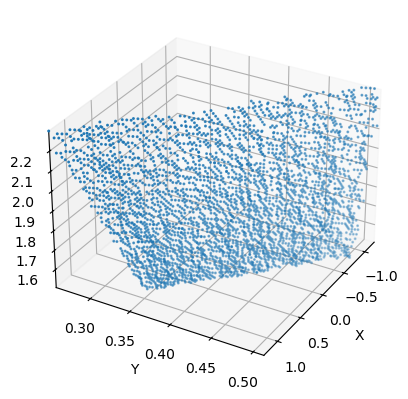

In [8]:
plot_point_and_plane(clear_table, fig_save_location="../figs/Q4_clear_table_points.png")

Points are in units of meters and the positive x-direction is right, positive y-direction is down, and positive z-direction is forward.
Find the least-squares approximation plane that fits the data.
Visualize your fitted plane along with the data.
What is the average distance of a point in the data set to the fitted plane?

**Comment:** The phrase “least-squares” is ambiguous. Below are descriptions of two possibilities that might occur to you.
**Please use Linear Regression.**
That approach is similar to our discussion of the normal equations in lecture.

**Orthogonal-Distance Regression:** In this approach, one computes the SVD decomposition of the $n \times 3$ matrix whose rows are the data points translated so their centroid is at the origin.
It turns out that the third column of V is normal to a plane that minimizes the sum of squared orthogonal distances between the translated points and the plane.
(This is a nice result to know.)

**Linear Regression:** This regression is based on the idea that, for perfectly planar data, all the points would satisfy a plane equation of the form $ax + by + cz + d = 0$.
So one has a natural error $\sum_i (ax_i + by_i + cz_i + d)^2$, with i indexing the data points.
One chooses the coefficients $\{a, b, c, d\}$ so as to minimize this error.
In order to avoid degeneracies, one requires that not all of $\{a, b, c, d\}$ be 0.

**Please use this approach.**

(Additional comments: (i) One convenient approach is to set one of the coefficients $\{a, b, c, d\}$ to be 1 or -1 while letting the others vary in order to compute the best plane.
(ii) Observe that $|ax_i + by_i + cz_i + d|$ is related to but not necessarily exactly the distance of the ith data point from the plane described by $\{a, b, c, d\}$.)

$$
A^T A p = - A^T \mathbf{1} \\
d = 1 \\
p = [a, b, c]^T
$$

In [9]:
coeff = fit_plane(clear_table)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(f"Average distance is {average_point_to_plane_distance(clear_table, coeff)}")

Plane equation:
-0.0951113342629671⋅x - 0.994246831912656⋅y - 0.0492653156527438⋅z + 0.4937029 ↪

↪ 32302467 = 0
Average distance is 0.0027402506617573534


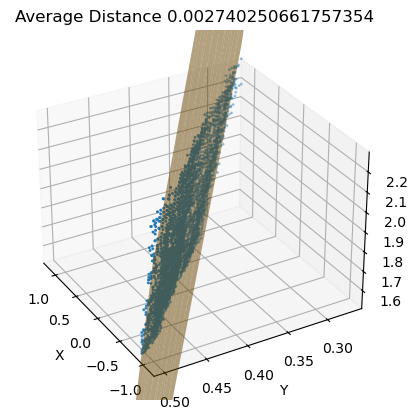

In [10]:
plot_point_and_plane(
    clear_table,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_clear_table_plane.png",
    elev=30,
    azim=150,
)

In [11]:
open3d_vis(clear_table, plane_coeffs=coeff)

b) Interested in your gecko robot, your cat jumps up on the table.
You take a second observation, saved as the provided cluttered table.txt.
Using the same method as above, find the least-squares fit to the new data.
How does it look? Why?

In [12]:
cluttered_table = np.loadtxt("../data/cluttered_table.txt")
cluttered_table.shape

(3888, 3)

In [13]:
coeff = fit_plane(cluttered_table)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(f"Average distance is {average_point_to_plane_distance(cluttered_table, coeff)}")

Plane equation:
-0.0975611845981769⋅x - 0.973054533289032⋅y - 0.208917903745619⋅z + 0.77411921 ↪

↪ 9789838 = 0
Average distance is 0.03741737808121337


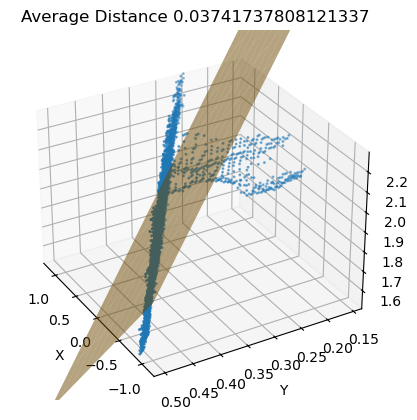

In [14]:
plot_point_and_plane(
    cluttered_table,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_cluttered_table_plane.png",
    elev=30,
    azim=150,
)

c) Can you suggest a way to still find a fit to the plane of the table regardless of clutter?
Verify your idea by writing a program that can successfully find the dominant plane in a list of points regardless of outliers.
        [Hint: You may assume that the number of points in the plane is much larger than the number of points not in the plane.]
Visualize cluttered\_table.txt with your new plane.

In [15]:
def RANSAC_fit_plane(
    points: np.array,
    max_iter: int = 10000,
    sample_ratio: float = 0.01,
    distance_inlier_threshold: float = 0.01,
) -> np.array:
    """Fit a plane to a set of noisy 3D points using RANSAC.

    Args:
        points (np.array): points in shape (N, 3)
        max_iter (int, optional): maximum iteration to perform random sampling. Defaults to 10000.
        sample_ratio (float, optional): the amount of points to sample, sample_ratio * N. Defaults to 0.01. Will not be less than 10.
        distance_inlier_threshold (float, optional): inlier points maximum average distance to their fitted plane. Defaults to 0.01.

    Raises:
        ValueError: No inlier points found.

    Returns:
        np.array: inlier points
    """
    NUM_POINTS = points.shape[0]
    SAMPLE_SIZE = max(int(points.shape[0] * sample_ratio), 10)

    inlier_index = np.array([], dtype=int)

    for _ in range(max_iter):
        # randomly sample SAMPLE_SIZE points index
        random_index = np.random.permutation(np.arange(NUM_POINTS, dtype=int))[
            :SAMPLE_SIZE
        ]

        coeff = fit_plane(points[random_index])
        distance = average_point_to_plane_distance(points[random_index], coeff)
        if distance <= distance_inlier_threshold:
            inlier_index = np.append(inlier_index, random_index)
            inlier_index = np.sort(inlier_index)
            inlier_index = np.unique(inlier_index)

    if inlier_index.size == 0:
        raise ValueError("No inlier found.")

    print(f"Inliers ratio: {inlier_index.size / NUM_POINTS}")
    return points[inlier_index]

In [16]:
table_points = RANSAC_fit_plane(
    cluttered_table, max_iter=100000, sample_ratio=0.001, distance_inlier_threshold=0.01
)

Inliers ratio: 0.9318415637860082


In [17]:
coeff = fit_plane(table_points)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(
    f"Average distance to all the points is {average_point_to_plane_distance(cluttered_table, coeff)}"
)
inlier_distance = average_point_to_plane_distance(table_points, coeff)
print(
    f"Average distance to table points is {average_point_to_plane_distance(table_points, coeff)}"
)

Plane equation:
-0.100675331096818⋅x - 0.992893001585378⋅y - 0.0634662517510272⋅z + 0.51861773 ↪

↪ 901684 = 0
Average distance to all the points is 0.0157371563893876
Average distance to table points is 0.005109289038397929


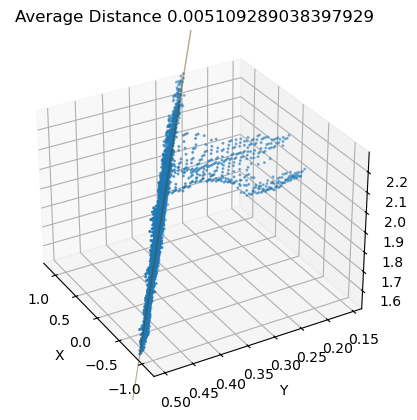

In [18]:
plot_point_and_plane(
    cluttered_table,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_cluttered_table_plane_ransac.png",
    elev=30,
    azim=150,
    distance=average_point_to_plane_distance(table_points, coeff),
)

In [19]:
open3d_vis(cluttered_table, plane_coeffs=coeff)

d) Encouraged by your results when testing on a table, you move your geckobot into the hallway and take an observation saved as the provided clean\_hallway.txt.
Describe an extension to your solution to part (c) that finds the four dominant planes shown in the scene, then implement it and visualize the data and the four planes.

You may assume that there are roughly the same amount of points in each plane.

In [20]:
clean_hallway = np.loadtxt("../data/clean_hallway.txt")
clean_hallway.shape

(16524, 3)

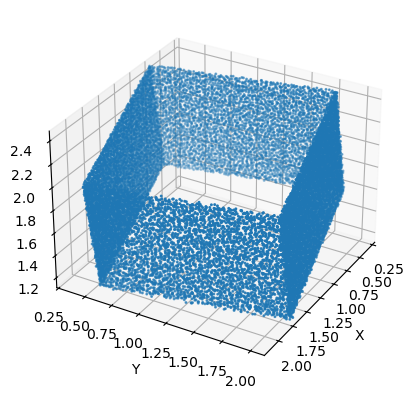

In [21]:
plot_point_and_plane(
    clean_hallway, fig_save_location="../figs/Q4_clean_hallway_points.png"
)

In [22]:
def RANSAC_fit_plane_extended(
    points: np.array,
    num_planes: int,
    max_iter: int = 10000,
    sample_ratio: float = 0.001,
    distance_inlier_threshold: float = 0.01,
) -> np.array:
    """extended RANSAC to fit multiple planes, inlier points must satisfy:
    1. Itself is a plane with small average distance
    2. Its fitted plane must be the same plane with existing inliers
    3. The fitted plane's close to enough points (1/num_planes * 0.9)

    Args:
        points (np.array): points in shape (N, 3)
        num_planes (int): number of planes to fit, assuming each plane has roughly the same number of inliers
        max_iter (int, optional): maximum iteration to perform random sampling. Defaults to 10000.
        sample_ratio (float, optional): the amount of points to sample, sample_ratio * N. Defaults to 0.0001. Will not be less than 5.
        distance_inlier_threshold (float, optional): inlier points maximum average distance to their fitted plane. Defaults to 0.01.

    Raises:
        ValueError: No inlier points found.

    Returns:
        np.array: inlier points, might not be most points in its plane
    """
    NUM_POINTS = points.shape[0]
    SAMPLE_SIZE = max(int(points.shape[0] * sample_ratio), 5)

    print(f"Number of points: {NUM_POINTS}")
    print(f"Sample size: {SAMPLE_SIZE}")

    inlier_index = np.array([], dtype=int)

    points_homo = np.hstack((points, np.ones((points.shape[0], 1))))

    for iter in range(max_iter):
        # randomly sample SAMPLE_SIZE points index
        random_index = np.random.permutation(np.arange(NUM_POINTS, dtype=int))[
            :SAMPLE_SIZE
        ]

        extended_index = np.unique(np.append(inlier_index, random_index))

        coeff = fit_plane(points[random_index])
        distance = average_point_to_plane_distance(points[random_index], coeff)
        extended_distance = average_point_to_plane_distance(
            points[extended_index], coeff
        )

        all_distances = np.abs(points_homo @ coeff)
        num_inliers = np.where(all_distances <= distance_inlier_threshold)[0].size
        inliers_ratio = num_inliers / NUM_POINTS

        # print(f"inliers_ratio = {inliers_ratio}")

        # Must satisfy: itself is a plane, it's the same plane with inliers, and it has enough inliers
        if (
            distance <= distance_inlier_threshold
            and extended_distance <= distance_inlier_threshold
            and inliers_ratio > 1 / num_planes * 0.9
        ):
            inlier_index = np.append(inlier_index, random_index)
            inlier_index = np.sort(inlier_index)
            inlier_index = np.unique(inlier_index)

    if inlier_index.size == 0:
        raise ValueError("No inlier found.")

    print(f"Inliers ratio: {inlier_index.size / NUM_POINTS}")
    return points[inlier_index]

In [23]:
inlier_points = RANSAC_fit_plane_extended(
    clean_hallway,
    num_planes=4,
    max_iter=15000,
    sample_ratio=0.0001,
    distance_inlier_threshold=0.01,
)

Number of points: 16524
Sample size: 5
Inliers ratio: 0.004175744371822803


In [24]:
coeff = fit_plane(inlier_points)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(
    f"Average distance to all the points is {average_point_to_plane_distance(clean_hallway, coeff)}"
)
inlier_distance = average_point_to_plane_distance(inlier_points, coeff)
print(
    f"Average distance to table points is {average_point_to_plane_distance(inlier_points, coeff)}"
)

Plane equation:
0.167171403175815⋅x - 0.985200262662702⋅y - 0.0378703632088821⋅z + 0.213306238 ↪

↪ 705385 = 0
Average distance to all the points is 0.8044052663416138
Average distance to table points is 0.0031652072513714278


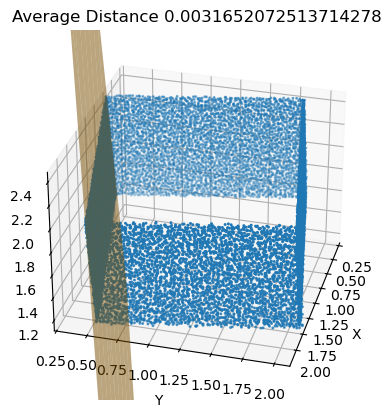

In [25]:
plot_point_and_plane(
    clean_hallway,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_clean_hallway_plane_ransac_1.png",
    distance=inlier_distance,
    elev=30,
    azim=15,
)

In [26]:
open3d_vis(clean_hallway, plane_coeffs=coeff)

In [27]:
coeffs = []
coeffs.append(fit_plane(inlier_points))

## Remove 1 Plane

In [28]:
# Remove points close to this plane and fit for other planes
clean_hallway_homo = np.hstack((clean_hallway, np.ones((clean_hallway.shape[0], 1))))
clean_hallway_remain_points = np.delete(
    clean_hallway, np.where(np.abs(clean_hallway_homo @ coeff) <= 0.01)[0], axis=0
)
clean_hallway_remain_points.shape

(12331, 3)

In [29]:
inlier_points = RANSAC_fit_plane_extended(
    clean_hallway_remain_points,
    num_planes=4,
    max_iter=15000,
    sample_ratio=0.0001,
    distance_inlier_threshold=0.01,
)

Number of points: 12331
Sample size: 5
Inliers ratio: 0.025707566296326333


In [30]:
coeff = fit_plane(inlier_points)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(
    f"Average distance to all the points is {average_point_to_plane_distance(clean_hallway, coeff)}"
)
inlier_distance = average_point_to_plane_distance(inlier_points, coeff)
print(
    f"Average distance to table points is {average_point_to_plane_distance(inlier_points, coeff)}"
)

Plane equation:
0.170145092274587⋅x - 0.984764875116536⋅y - 0.0358996979316684⋅z + 1.806131794 ↪

↪ 32628 = 0
Average distance to all the points is 0.7979796344720125
Average distance to table points is 0.0038163079260095855


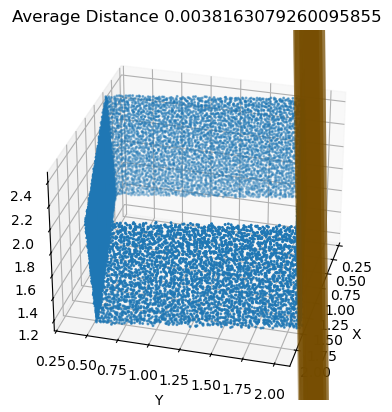

In [31]:
plot_point_and_plane(
    clean_hallway,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_clean_hallway_plane_ransac_2.png",
    distance=inlier_distance,
    elev=30,
    azim=15,
)

In [32]:
open3d_vis(clean_hallway, plane_coeffs=coeff)

In [33]:
coeffs.append(fit_plane(inlier_points))

## Remove 2 Planes

In [34]:
# Remove points close to this plane and fit for other planes
clean_hallway_remain_points_homo = np.hstack(
    (clean_hallway_remain_points, np.ones((clean_hallway_remain_points.shape[0], 1)))
)
clean_hallway_remain_points_2 = np.delete(
    clean_hallway_remain_points,
    np.where(np.abs(clean_hallway_remain_points_homo @ coeff) <= 0.01)[0],
    axis=0,
)
clean_hallway_remain_points_2.shape

(8098, 3)

In [35]:
inlier_points = RANSAC_fit_plane_extended(
    clean_hallway_remain_points_2,
    num_planes=4,
    max_iter=15000,
    sample_ratio=0.0001,
    distance_inlier_threshold=0.01,
)

Number of points: 8098
Sample size: 5
Inliers ratio: 0.12027661150901457


In [36]:
coeff = fit_plane(inlier_points)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(
    f"Average distance to all the points is {average_point_to_plane_distance(clean_hallway, coeff)}"
)
inlier_distance = average_point_to_plane_distance(inlier_points, coeff)
print(
    f"Average distance to table points is {average_point_to_plane_distance(inlier_points, coeff)}"
)

Plane equation:
-0.964117119358912⋅x - 0.171825847996477⋅y + 0.20237109012743⋅z + 1.8193390031 ↪

↪ 6273 = 0
Average distance to all the points is 0.8083965696706051
Average distance to table points is 0.007721083799926592


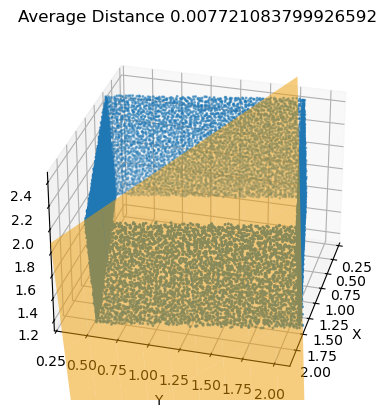

In [37]:
plot_point_and_plane(
    clean_hallway,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_clean_hallway_plane_ransac_3.png",
    distance=inlier_distance,
    elev=30,
    azim=15,
)

In [38]:
open3d_vis(clean_hallway, plane_coeffs=coeff)

In [39]:
coeffs.append(fit_plane(inlier_points))

# Remove 3 Planes

In [40]:
# Remove points close to this plane and fit for other planes
clean_hallway_remain_points_homo_2 = np.hstack(
    (
        clean_hallway_remain_points_2,
        np.ones((clean_hallway_remain_points_2.shape[0], 1)),
    )
)
clean_hallway_remain_points_3 = np.delete(
    clean_hallway_remain_points_2,
    np.where(np.abs(clean_hallway_remain_points_homo_2 @ coeff) <= 0.01)[0],
    axis=0,
)
clean_hallway_remain_points_3.shape

(5693, 3)

In [41]:
inlier_points = RANSAC_fit_plane_extended(
    clean_hallway_remain_points_3,
    num_planes=4,
    max_iter=15000,
    sample_ratio=0.0001,
    distance_inlier_threshold=0.01,
)

Number of points: 5693
Sample size: 5


Inliers ratio: 0.6648515721060952


In [42]:
coeff = fit_plane(inlier_points)

# Construct the equation of the plane
x, y, z = sp.symbols("x y z", real=True)
plane = sp.Eq(coeff[0] * x + coeff[1] * y + coeff[2] * z + coeff[3], 0)

print("Plane equation:")
sp.pprint(plane)

print(
    f"Average distance to all the points is {average_point_to_plane_distance(clean_hallway, coeff)}"
)
inlier_distance = average_point_to_plane_distance(inlier_points, coeff)
print(
    f"Average distance to table points is {average_point_to_plane_distance(inlier_points, coeff)}"
)

Plane equation:
-0.963977740041246⋅x - 0.174301768552968⋅y + 0.200912444075222⋅z + 0.218729125 ↪

↪ 059114 = 0
Average distance to all the points is 0.8011210767581796
Average distance to table points is 0.005004247726805122


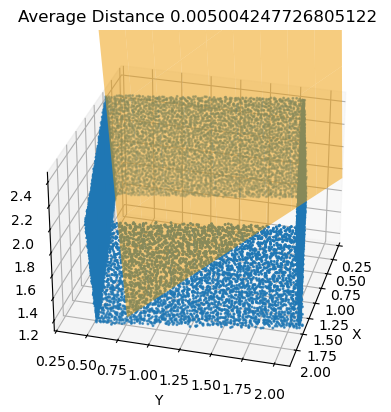

In [43]:
plot_point_and_plane(
    clean_hallway,
    plane_coeffs=coeff,
    fig_save_location="../figs/Q4_clean_hallway_plane_ransac_4.png",
    distance=inlier_distance,
    elev=30,
    azim=15,
)

In [44]:
open3d_vis(clean_hallway, plane_coeffs=coeff)

In [45]:
coeffs.append(fit_plane(inlier_points))

# Visualize 4 Planes

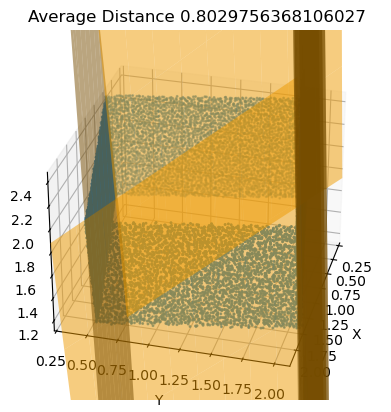

In [46]:
plot_point_and_plane(
    clean_hallway,
    plane_coeffs=np.array(coeffs),
    fig_save_location="../figs/Q4_clean_hallway_plane_ransac_all.png",
    elev=30,
    azim=15,
)

In [47]:
open3d_vis(clean_hallway, plane_coeffs=np.array(coeffs))

e) You decide it is time to test your gecko robot's suction feet and move it to a different hallway.
The feet are strong enough to ignore the force of gravity, allowing the robot to walk on the floor, walls, or ceiling.
However, the locomotion of the legs works best on smooth surfaces with few obstacles.
Using your solution from part (d), describe how you can mathematically characterize the smoothness of each surface.
Load the provided scan cluttered\_hallway.txt, find and plot the four wall planes, describe which surface is safest for your robot to traverse, and provide the smoothness scores from your mathematical characterization.

In [48]:
cluttered_hallway = np.loadtxt("../data/cluttered_hallway.txt")
cluttered_hallway.shape

(14594, 3)

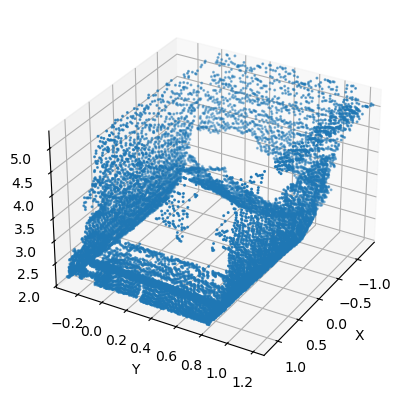

In [49]:
plot_point_and_plane(
    cluttered_hallway, fig_save_location="../figs/Q4_cluttered_hallway_points.png"
)

In [50]:
open3d_vis(cluttered_hallway)

In [122]:
def voxel_downsample_point_cloud(points, voxel_size):
    """
    Downsamples the input point cloud using a voxel grid filter.

    Args:
        points (np.array): Input points in shape (N, 3).
        voxel_size (float): The size of the voxel grid.

    Returns:
        np.array: Downsampled points in shape (M, 3).
    """
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Downsample
    downsampled_pcd = pcd.voxel_down_sample(voxel_size)

    # Extract NumPy array
    downsampled_points = np.asarray(downsampled_pcd.points)

    return downsampled_points

In [138]:
downsampled_hallway = voxel_downsample_point_cloud(cluttered_hallway, 0.1)

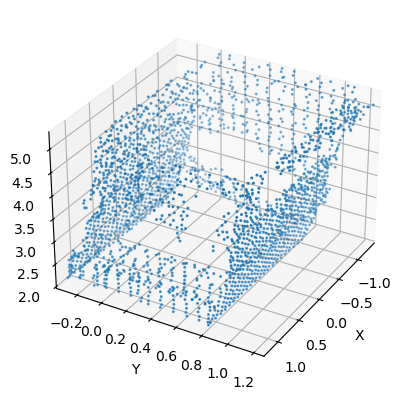

In [139]:
plot_point_and_plane(
    downsampled_hallway,
    fig_save_location="../figs/Q4_cluttered_hallway_downsampled.png",
)

In [140]:
open3d_vis(downsampled_hallway)

In [162]:
def RANSAC_fit_multiple_planes(
    points: np.array,
    num_planes: int,
    max_iter: int = 10000,
    sample_size: int = 5,
    distance_threshold: float = 0.01,
    inlier_ratio: float = 0.9,
):
    """Fit multiple planes to a set of 3D points using RANSAC.

    Args:
        points (np.array): Points in shape (N, 3).
        num_planes (int): Number of planes to fit.
        max_iter (int, optional): Maximum iterations for RANSAC. Defaults to 10000.
        sample_size (int, optional): number of points to sample for every RANSAC iteration. Defaults to 5.
        distance_threshold (float, optional): Distance threshold for inliers. Defaults to 0.01.
        min_inliers (int, optional): Minimum number of inliers to accept a plane. Adjust as needed.

    Returns:
    """
    points = points.copy().reshape(-1, 3)
    remaining_points = points.copy().reshape(-1, 3)

    planes = []

    for i in range(num_planes)[::-1]:
        print(f"Fitting plane {i + 1}...")

        min_inliers = int(remaining_points.shape[0] / (i + 1) * inlier_ratio)

        inlier_indices = np.array([], dtype=int)
        # Can no longer assume the same number of inliers for each plane
        for _ in range(max_iter):
            # Randomly sample points
            sample_indices = np.random.permutation(
                np.arange(remaining_points.shape[0], dtype=int)
            )[:sample_size]
            extended_index = np.unique(np.append(inlier_indices, sample_indices))
            sample_points = remaining_points[sample_indices]

            # Fit a plane to the sample points
            plane_coefficients = fit_plane(sample_points)

            fit_distance = average_point_to_plane_distance(
                sample_points, plane_coefficients
            )
            inlier_distance = average_point_to_plane_distance(
                remaining_points[extended_index], plane_coefficients
            )

            all_distances = np.abs(
                remaining_points @ plane_coefficients[:3] + plane_coefficients[3]
            )
            num_inliers = np.where(all_distances <= distance_threshold)[0].size

            if (
                fit_distance <= distance_threshold
                and inlier_distance <= distance_threshold
                and num_inliers >= min_inliers
            ):
                inlier_indices = np.append(inlier_indices, sample_indices)
                inlier_indices = np.sort(inlier_indices)
                inlier_indices = np.unique(inlier_indices)

        if inlier_indices.size > 0:
            print(f"Found {inlier_indices.size} inliers.")
            coeff = fit_plane(remaining_points[inlier_indices])

            # find all points that are close to this plane in points
            distance_all_points = np.abs(points @ coeff[:3] + coeff[3])
            point_close_to_this_plane = points[
                np.where(distance_all_points <= distance_threshold)
            ]
            distance_close_to_this_plane = distance_all_points[
                np.where(distance_all_points <= distance_threshold)
            ]
            print(f"Points close to this plane: {point_close_to_this_plane.shape[0]}")
            planes.append(
                {
                    "coeff": fit_plane(point_close_to_this_plane),
                    "mean_distance": distance_close_to_this_plane.mean(),
                    "var_distance": distance_close_to_this_plane.var(),
                    "var_distance_all": distance_all_points.var(),
                    "points": point_close_to_this_plane,
                    "num_points": point_close_to_this_plane.shape[0],
                }
            )

            # remove all points close to this plane from remaining points
            distance_remaining_points = np.abs(remaining_points @ coeff[:3] + coeff[3])
            remaining_points = remaining_points[
                np.where(distance_remaining_points > distance_threshold)
            ]

            print(f"Remaining points: {remaining_points.shape[0]}")

    # Sort planes by number of points
    planes = sorted(planes, key=lambda x: x["num_points"], reverse=True)

    return planes

In [173]:
planes = RANSAC_fit_multiple_planes(
    downsampled_hallway, max_iter=50000, num_planes=4, inlier_ratio=0.6, sample_size=10
)

Fitting plane 4...
Found 20 inliers.
Points close to this plane: 595
Remaining points: 1779
Fitting plane 3...
Found 19 inliers.
Points close to this plane: 543
Remaining points: 1236
Fitting plane 2...
Fitting plane 1...


In [174]:
for i, plane in enumerate(planes):
    print(f"Plane {i + 1}:")
    print(f"\tNumber of points: {plane["num_points"]}")
    print(f"\tMean distance: {plane["mean_distance"]}")
    print(f"\tVariance distance: {plane["var_distance"]}")
    print(f"\tVariance distance all: {plane["var_distance_all"]}")
    x, y, z = sp.symbols("x y z", real=True)
    plane_eq = sp.Eq(plane["coeff"][0] * x + plane["coeff"][1] * y + plane["coeff"][2] * z + plane["coeff"][3], 0)
    print(f"\tPlane equation:")
    sp.pprint(plane_eq)

Plane 1:
	Number of points: 595
	Mean distance: 0.0039050967482275882
	Variance distance: 7.20804125922985e-06
	Variance distance all: 0.24873751491267126
	Plane equation:
0.0180113772483563⋅x + 0.995495709171525⋅y - 0.0930799834051354⋅z + 0.53498621 ↪

↪ 3611912 = 0
Plane 2:
	Number of points: 543
	Mean distance: 0.0035446492378242746
	Variance distance: 6.958371198955975e-06
	Variance distance all: 0.24548722548832
	Plane equation:
-0.0134299102483403⋅x - 0.994749138160533⋅y + 0.101458314787885⋅z + 0.58235078 ↪

↪ 4438808 = 0


In [175]:
coeffs = [plane["coeff"] for plane in planes[:4]]

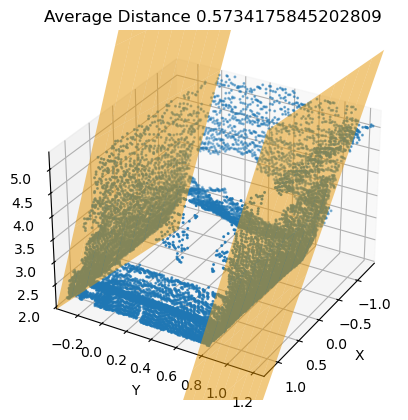

In [176]:
plot_point_and_plane(
    cluttered_hallway,
    plane_coeffs=np.array(coeffs),
    fig_save_location="../figs/Q4_cluttered_hallway_planes.png",
)

In [178]:
open3d_vis(cluttered_hallway, plane_coeffs=np.array(coeffs))

Note that you may no longer assume that there are roughly the same amount of points in each plane.

Parts (c), (d), and (e) intentionally leave room for some creativity and design.
There may be several good approaches.

Please submit code for all parts (a), (b), (c), (d), (e) of this problem.
In your pdf, explain what you did, how to run your code, and what results you obtained.
Describe any design decisions you made.
Include as well in your pdf any images you used to visualize data, and explain their meanings.
Finally, replicate in your pdf any code you would like the TAs to see.